Lesson 09

Author: Rodrigo MM Santiago @rodrigommsantiago

In [11]:
# Modules...
import numpy as np              # numeric
import matplotlib.pyplot as plt # plotting

# inline plots
%matplotlib inline 


# Filters, power spectra and hilbert transform functions
from scipy.signal import welch, spectrogram, butter, filtfilt, hilbert

import pylab as pl          # animations
from IPython import display # display tools
from time import sleep      # pausing functions

Signal amplitude via Hilbert transform:<br>
The function "hilbert" returns the analytical representation of a signal (the complex plane representation), x(t) = |x| + iH[x(t)], and not the Hilbert transform, which is the imaginary part H[x(t)] of this representation.

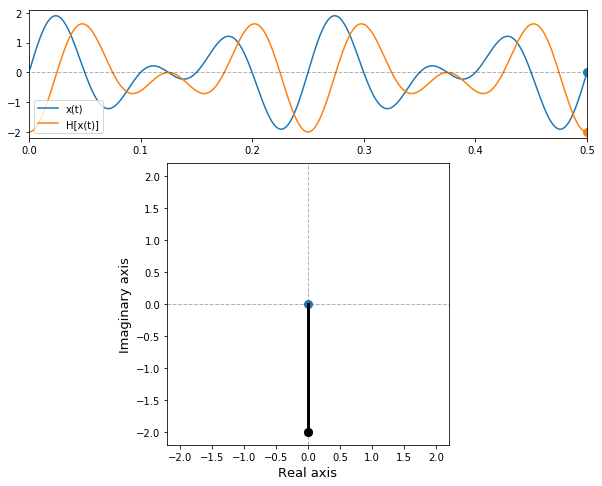

In [13]:
srate = 1000
dt = 1./srate
t = np.arange(dt,10.0001,dt)

LFP = np.sin(2*np.pi*8*t)+np.sin(2*np.pi*12*t)

Analytical_LFP = hilbert(LFP)
hilbert_transform = np.imag(Analytical_LFP )
sinal_original = np.real(Analytical_LFP )

plt.figure(figsize=(10,8))

ax1 = plt.subplot2grid((3, 1), (0, 0))
ax1.plot(t,LFP,label='x(t)')
ax1.plot(t,hilbert_transform,label='H[x(t)]')
ax1.set_xlim(0,0.5)
ax1.legend()

ax2 = plt.subplot2grid((3, 1), (1, 0),rowspan=2)
ax2.axis('square')
ax2.set_xlim(-2.2,2.2)
ax2.set_ylim(-2.2,2.2)
counter = 500
ax1.plot([-2.2,2.2],[0,0],'k--',linewidth=1,alpha=0.3)
ax2.plot([-2.2,2.2],[0,0],'k--',linewidth=1,alpha=0.3)
ax2.plot([0,0],[-2.2,2.2],'k--',linewidth=1,alpha=0.3)
for n in range(counter):
    pReal_ax1 = ax1.plot(t[n],sinal_original[n],'C0o',markersize=8)
    pReal_ax2 = ax2.plot(sinal_original[n],0,'C0o',markersize=8)
    pImag_ax1 = ax1.plot(t[n],hilbert_transform[n],'C1o',markersize=8)
    pImag_ax2 = ax2.plot(0,hilbert_transform[n],'C1o',markersize=8)
    line = ax2.plot([0,LFP[n]],[0,hilbert_transform[n]],'k',linewidth=3)
    pointLine = ax2.plot(LFP[n],hilbert_transform[n],'ko',markersize=8)
    ax2.set_xlabel('Real axis',size=13)
    ax2.set_ylabel('Imaginary axis',size=13)
    display.display(pl.gcf())       # shows animated plot
    display.clear_output(wait=True) # holds display for next plot
    if n < counter-1:
        line[-1].remove()
        pReal_ax1[-1].remove()
        pReal_ax2[-1].remove()
        pImag_ax1[-1].remove()
        pImag_ax2[-1].remove()
        pointLine[-1].remove()

Amplitude envelope:

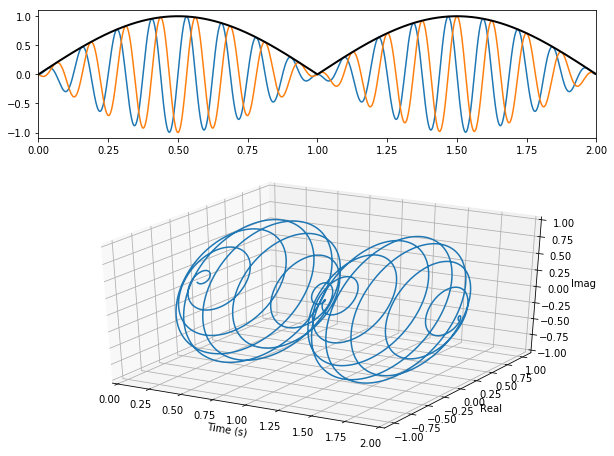

In [14]:
LFP = np.sin(2*np.pi*8*t)*np.sin(2*np.pi*0.5*t)

LFP_A = hilbert(LFP) # LFP analytical representation
AmpEnv = np.abs(LFP_A)
Ht = np.imag(LFP_A)

plt.figure(figsize=(10,8))

ax1 = plt.subplot2grid((3, 1), (0, 0))
ax1.plot(t,LFP)
ax1.plot(t,Ht)
ax1.plot(t,AmpEnv,'k',linewidth=2)
ax1.set_xlim(0,2)

#3D plotting
from mpl_toolkits.mplot3d import Axes3D

ax2 = plt.subplot2grid((3,1),(1,0),rowspan=2,projection='3d')
ax2.plot(t[t<=2],LFP[t<=2],Ht[t<=2])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Real')
ax2.set_zlabel('Imag')
ax2.set_xlim(0,2);

Computing the amplitude spectrum:



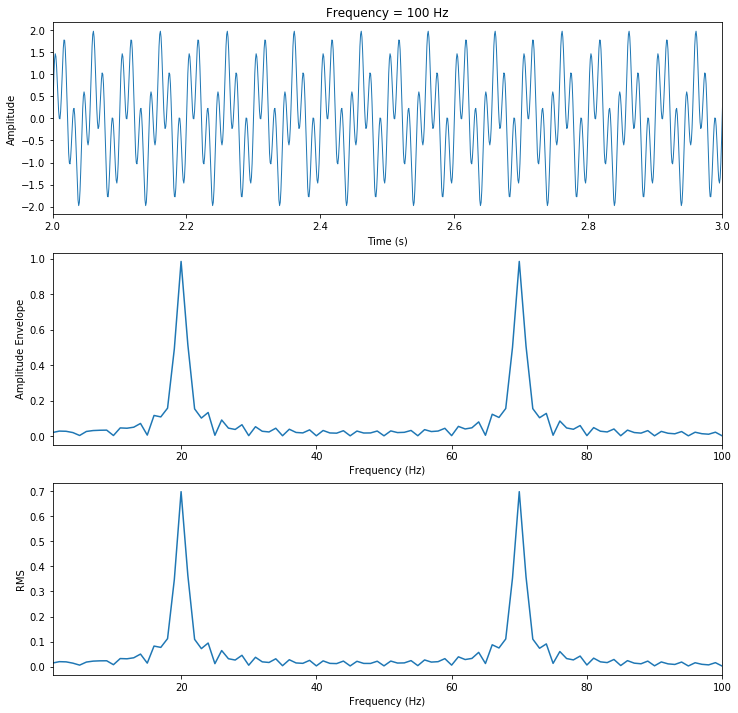

In [15]:
LFP = np.sin(2*np.pi*20*t)+np.sin(2*np.pi*70*t)

order = 600 # filt order
freqvector = np.arange(1,101) # analysed frequencies
Amp_spectrum = np.empty(len(freqvector)) # Amplitude via Hilbert transform
RMS_spectrum = np.empty(len(freqvector)) # Root Mean Square

plt.figure(figsize=(12,12))
plt.subplot(311)
plt.plot(t,LFP,linewidth=1)
for f in freqvector:
    kernel = np.sin(2*np.pi*f*t[:order])
    kernel = kernel/np.sum(kernel**2)
    filtered = np.convolve(LFP,kernel,'same')
    Amp_spectrum[f-1] = np.mean(np.abs(hilbert(filtered)))
    RMS_spectrum[f-1] = np.sqrt(np.mean(filtered**2))
    
    line1 = plt.plot(t,filtered,'C1')
    line2 = plt.plot(t,np.abs(hilbert(filtered)),'k',linewidth=2)
    plt.title('Frequency = '+str(f)+' Hz')
    plt.xlim(2,3)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    display.display(pl.gcf())       # shows animated plot
    display.clear_output(wait=True) # holds display for next plot
    sleep(0.1)
    line1[-1].remove()
    line2[-1].remove()

plt.subplot(312)    
plt.plot(freqvector,Amp_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Envelope')
plt.xlim(freqvector[0],freqvector[-1])

plt.subplot(313)
plt.plot(freqvector,RMS_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('RMS')
plt.xlim(freqvector[0],freqvector[-1]);

Computing the amplitude spectrum using *filtfilt*:

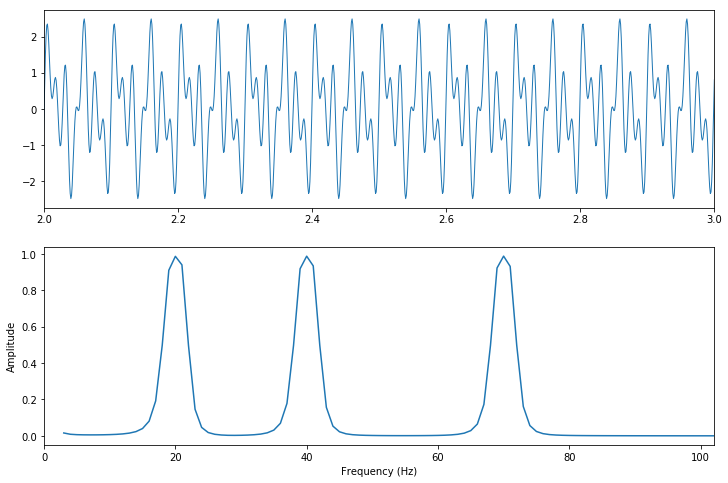

In [42]:
LFP = np.sin(2*np.pi*20*t)+np.sin(2*np.pi*40*t)+np.sin(2*np.pi*70*t)

freqvector = np.arange(1,101,1) # analysed frequencies
bandwidth  = 4 # bandwidth of the frequency range to be analysed on each iteration
order      = 2 # filt order
nyq        = 0.5*srate # Nyquist frequency

Amp_spectrum = np.empty(len(freqvector)) # Amplitude via Hilbert transform

for i,f_low in enumerate(freqvector):
    # Filtering the signal
    lowcut = f_low/nyq # normalized low cut frequency
    highcut = (f_low+bandwidth)/nyq # normalized high cut frequency
    # Butterworth transfer function
    b,a = butter(order,[lowcut,highcut],'bandpass', False)
    # Filtered signal
    filtered = filtfilt(b,a,LFP)
    # Amplitude envelope
    Amp_spectrum[i] = np.mean(np.abs(hilbert(filtered)))

plt.figure(figsize=(12,8))

plt.subplot(211)
plt.plot(t,LFP,linewidth=1)
plt.xlim(2,3)

plt.subplot(212)
plt.plot(freqvector+bandwidth/2.,Amp_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0,102);

Filtered signal amplitude envelope:

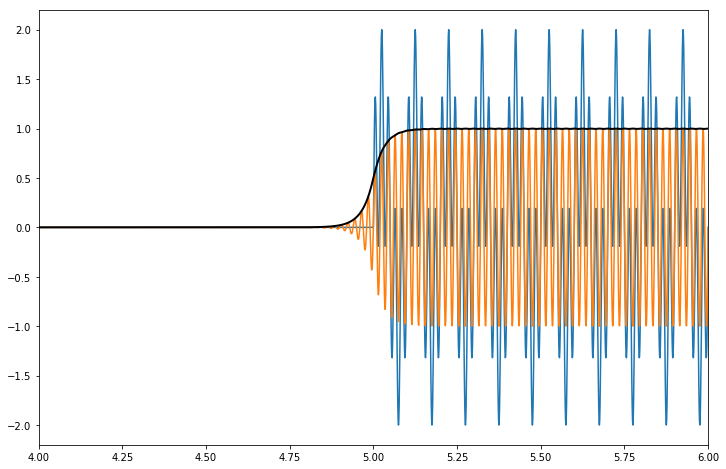

In [43]:
LFP = np.sin(2*np.pi*10*t)+np.sin(2*np.pi*50*t)
LFP[:5000] = 0

plt.figure(figsize=(12,8))
plt.plot(t,LFP)
plt.xlim([4,6])

order  = 1  # filt order
f_low  = 45 # low cut frequency
f_high = 55 # high cut frequency

# Filtering the signal
lowcut = f_low/nyq # normalized low cut frequency
highcut = f_high/nyq # nornmalized high cut frequency
# Butterworth transfer function
b,a = butter(order,[lowcut,highcut],'bandpass')
# filtered signal
filtered = filtfilt(b,a,LFP)
# amplitude envelope of filtered signal
ampenv = np.abs(hilbert(filtered))

plt.plot(t,filtered)
plt.plot(t,ampenv,'k-',linewidth=2);

TFD (Time-Frequency Decomposition):

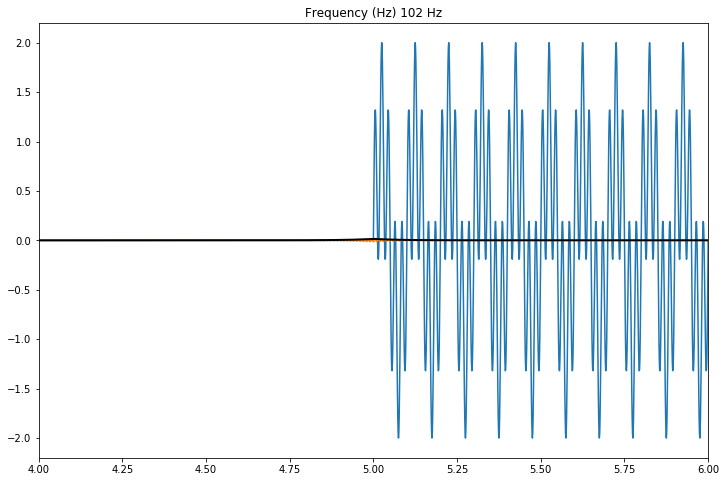

In [44]:
freqvector = np.arange(1,101,1)
TFD = np.empty((len(freqvector),len(t)))

plt.figure(figsize=(12,8))
plt.plot(t,LFP)


for i,f in enumerate(freqvector):
    # Filtering the signal
    lowcut = f/nyq # normalized low cut frequency
    highcut = (f+4)/nyq # nornmalized high cut frequency
    # Butterworth transfer function
    b,a = butter(order,[lowcut,highcut],'bandpass', False)
    # Filtered signal
    filtered = filtfilt(b,a,LFP)
    # Amplitude envelope
    ampenv = np.abs(hilbert(filtered))
    TFD[i] = ampenv
    
    lineFilt = plt.plot(t,filtered,'C1')
    lineAmpEnv = plt.plot(t,ampenv,'k',linewidth=2)
    plt.title('Frequency (Hz) '+str(f+2)+' Hz')
    plt.xlim([4,6])
    sleep(0.1)
    display.display(pl.gcf())       # shows animated plot
    display.clear_output(wait=True) # holds display for next plot
    if i < len(freqvector)-1:
        lineFilt[-1].remove()
        lineAmpEnv[-1].remove()

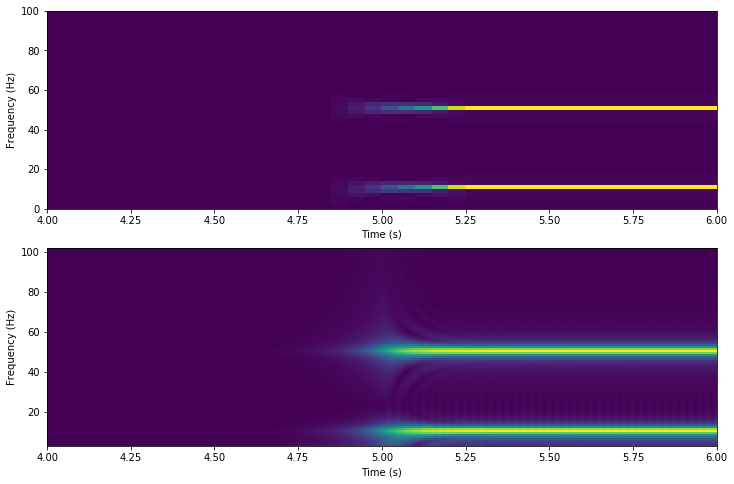

In [45]:
plt.figure(figsize=(12,8))

F,T,TFD2 = spectrogram(LFP,srate,nperseg=int(0.5*srate),noverlap=int(0.45*srate))
plt.subplot(211)
plt.pcolormesh(T,F,TFD2)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.xlim([4,6])
plt.ylim([0,100])

plt.subplot(212)
plt.pcolormesh(t,freqvector+2,TFD)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.xlim([4,6]);